In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import h5py
import PIL
import sys  
import os
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#from data.convert_distance_to_depth import * 
from set_method import my_method, Method


module_path = os.path.abspath(os.path.dirname(os.getcwd()))+"/../" # Only works if cwd correctly gets the model folder.


if module_path not in sys.path:
    sys.path.append(module_path)

from data.convert_distance_to_depth import *
from loaddata import *

from data.plot_scripts import * 

from set_method import *


In [3]:
#test_dataframe = pd.read_csv("../../data/downloads/image_file_test.csv")

# Validation from the cluster:
# Depth,Segmentation,ToneMapped
# ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5,ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5,ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg
#os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
# os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/home/user/Nextcloud/Documents/ETHZ/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
os.environ["THREED_VISION_ABSOLUTE_DOWNLOAD_PATH"] = "/Users/alicemazzoleni/Documents/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/data/downloads/"
download_path = os.getenv("THREED_VISION_ABSOLUTE_DOWNLOAD_PATH")


mean,std = [0.53277088, 0.49348648, 0.45927282],[0.238986 ,  0.23546355 ,0.24486044] 

if(torch.cuda.is_available()):
    device = "cuda:0"
else:
    device="cpu"

### Specify all the file paths

In [4]:
#choose validation images dataset path 
#validation_image_path = ["ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.depth_meters.hdf5","ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0006.semantic.hdf5","ai_001_001/images/scene_cam_00_final_preview/frame.0006.tonemap.jpg"] 
#validation_image_path_csv = "../outputs/results/"+ "valid_image.csv"
validation_image_path_csv = "valid_image.csv"
validation_depth_tensors = "../outputs/results/"+ "validation-.05-10-2023-14-59-41-depth.pt"

#choose test images dataset 

#choose training losses
train_progress_file = "train-.05-16-2023-23-16-38-Method.SEGMENTATIONMASKBOUNDARIES-results.csv"
training_progress_data = download_path + "../outputs/results/"+train_progress_file
# Choose the model to load here please:
model_checkpoint_file = "checkpointapple-.05-15-2023-20-09-01-Method.SEGMENTATIONMASKGRAYSCALE-final.pth.tar"
model_checkpoint_path = download_path+"../outputs/checkpoints/"+model_checkpoint_file

#set method
#NOSEGMENTATIONCUES, SEGMENTATIONMASKGRAYSCALE, SEGMENTATIONMASKBOUNDARIES, SEGMENTATIONMASKONEHOT
my_method = Method.SEGMENTATIONMASKGRAYSCALE


In [5]:
def test_sample(model, test_loader): 
    model.eval()
    depth_results = []
    if(torch.cuda.is_available()):
        model.to("cuda:0")
    else:model.to("cpu")
    for i, sample_batched in enumerate(test_loader):
        torch.cuda.empty_cache()
        
        image, depth = sample_batched['image'], sample_batched['depth']
        if(torch.cuda.is_available()):
            depth = depth.cuda(non_blocking=True) #
            image = image.cuda()
        image = torch.autograd.Variable(image, requires_grad=False)
        depth = torch.autograd.Variable(depth, requires_grad=False)
        output = model(image)
        output = torch.nn.functional.interpolate(output, size=[depth.size(2),depth.size(3)], mode='bilinear')
        #display_tensor_data(output[0,:].detach())
        #display_tensor_data(depth[0,:])
        #plt.imshow(output[0,:].permute(1, 2, 0).detach().numpy())
        #plt.show()
        depth_results.append([output.detach(),depth.detach() ,image.detach()])
        torch.cuda.empty_cache()
        
    return depth_results

### Loading the Model For testing

In [6]:
from train import define_model

# Model loading for prediction on test sample:

model = define_model(is_resnet = True, is_densenet=False, is_senet=False, pretrained = True)

state_dict = torch.load(model_checkpoint_path, map_location=torch.device(device))["state_dict"]

model.load_state_dict(state_dict=state_dict)
model.to(device=device)
model.eval();

torch.Size([64, 4, 7, 7])


In [7]:
# Load the data for testing

torch.cuda.empty_cache()
test_loader = getTestingData(1, validation_image_path_csv)
depth_results = test_sample(model, test_loader)

My Method in dataloader is:  Method.SEGMENTATIONMASKGRAYSCALE


/Users/alicemazzoleni/anaconda3/envs/3dVisionProject/lib/python3.9/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


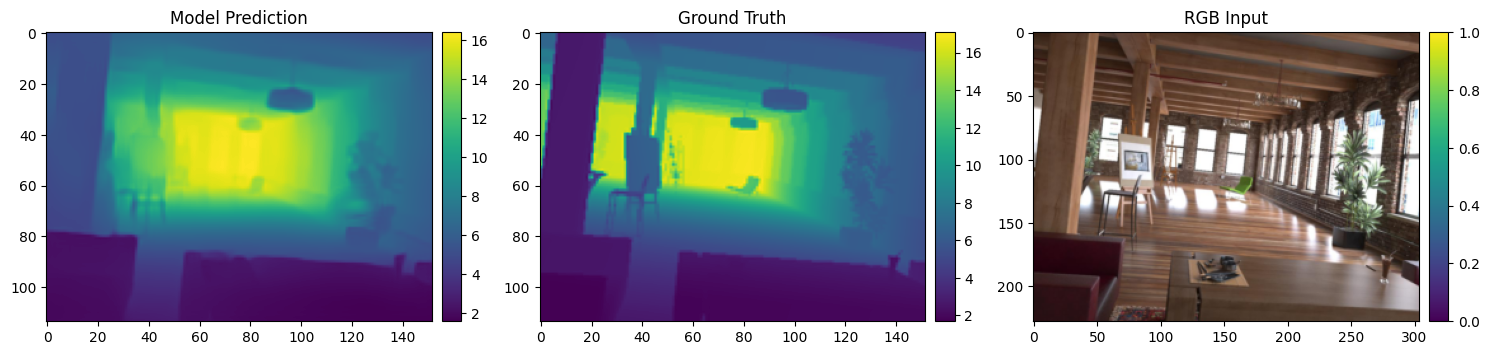

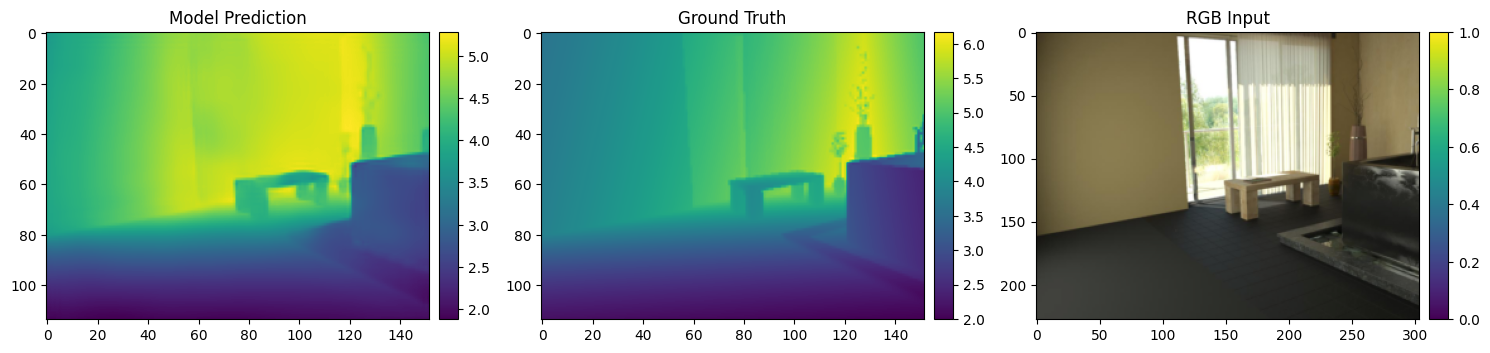

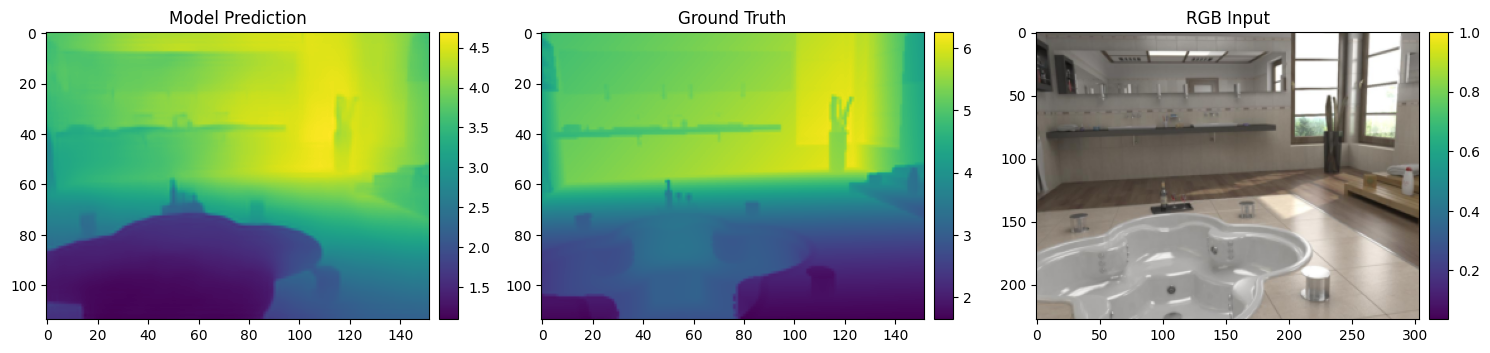

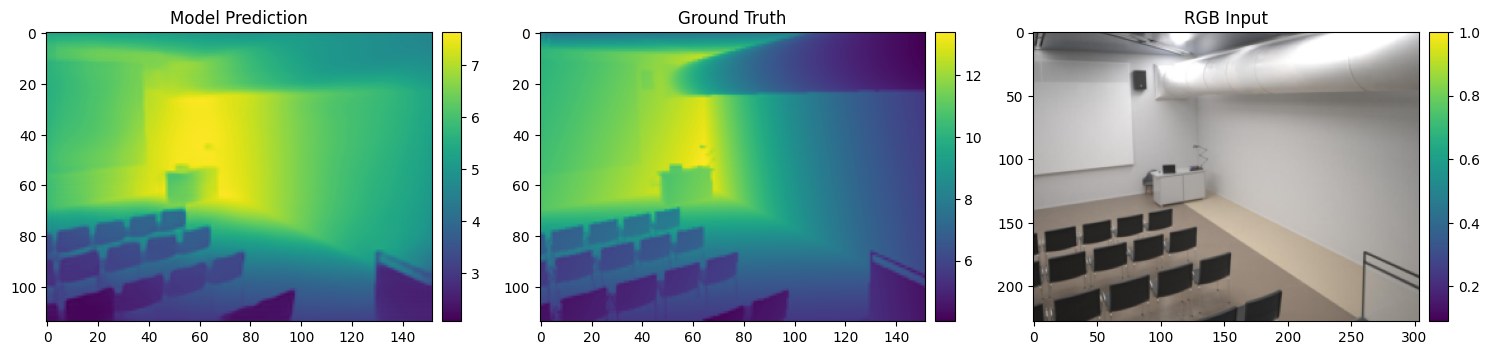

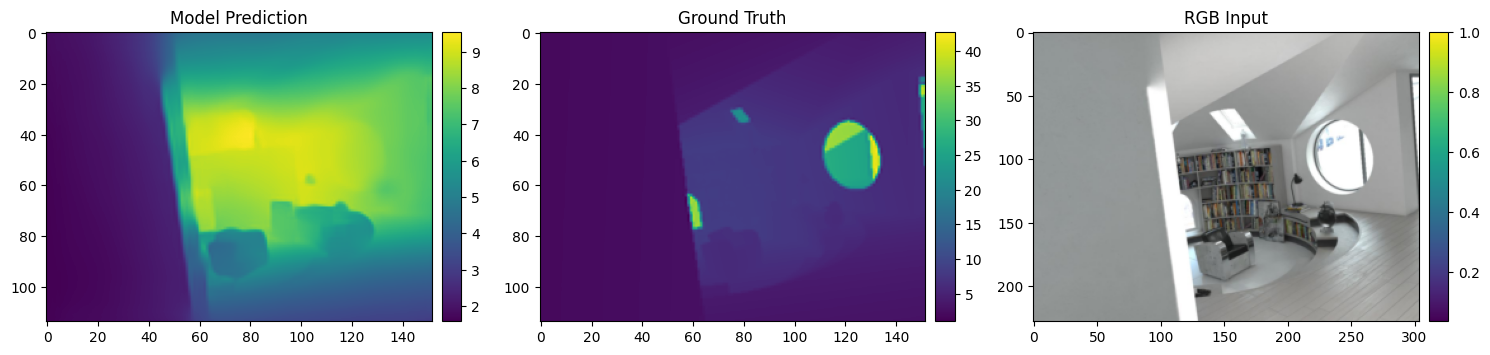

In [8]:
#plotname = "visual_plots_"+model_checkpoint_file[17:-14]
plotname = None
for i, tensors in enumerate(depth_results):
    outputs,depths,rgbs = tensors
    outputs = outputs[0,:,:,:].cpu()
    depths = depths[0,:,:,:].cpu()
    rgbs = rgbs[0,-3:,:,:].cpu()
    if(plotname != None):
        final_plotname = plotname + "_image_"+str(i)
    display_tensor_data_many(tensors=[outputs,depths,rgbs],remap=[None,None,denormalize], plot_name=final_plotname)
    #display_error_plots(depths, outputs)


## Plot for GrayScale Segmentation Masks

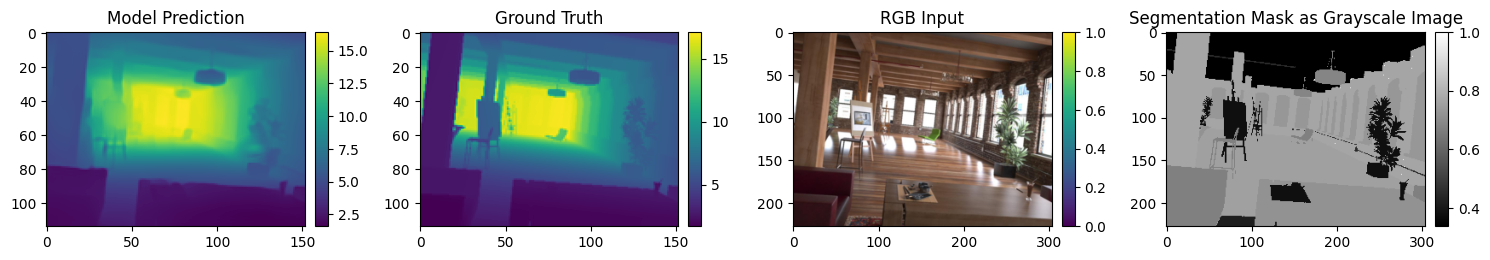

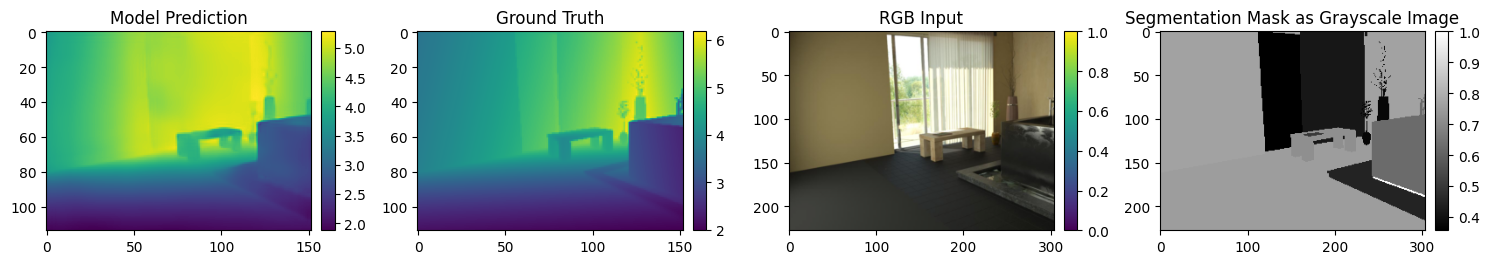

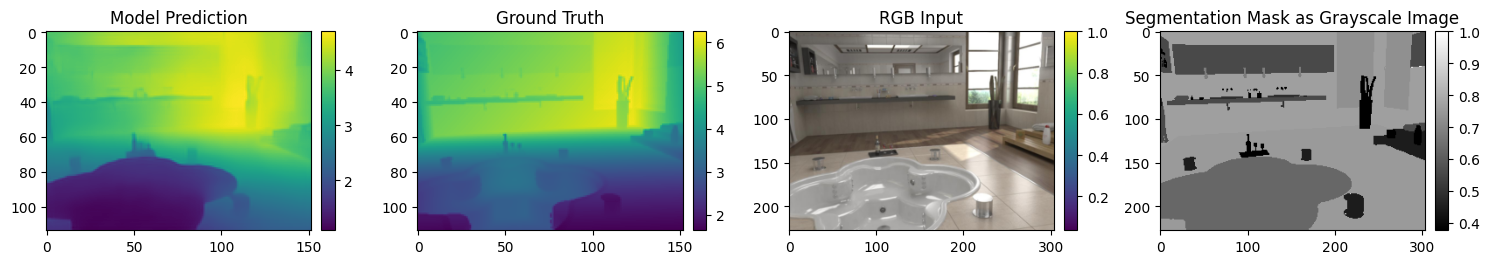

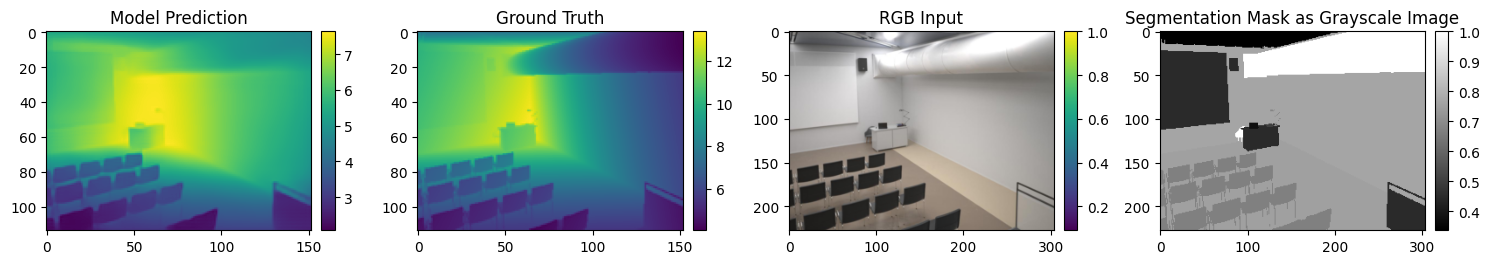

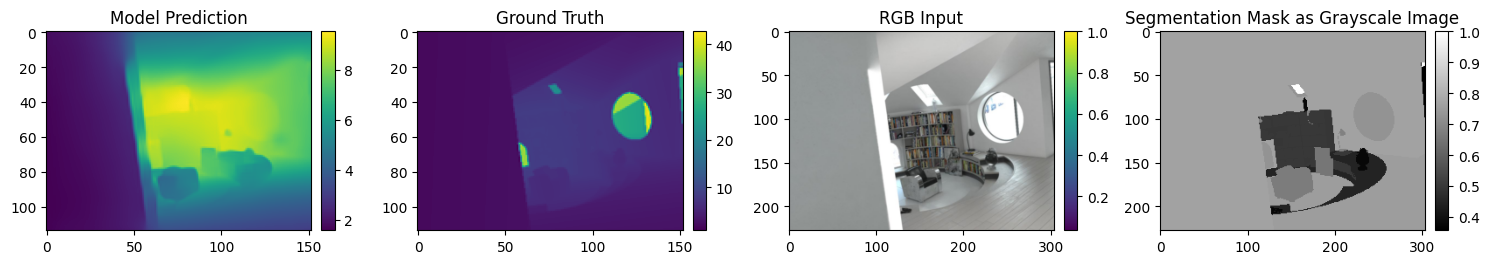

In [9]:
#plotname = "visual_plots_segmentation_"+model_checkpoint_file[17:-14]
plotname = None
for i, tensors in enumerate(depth_results):
    outputs,depths,rgbs = tensors
    outputs = outputs[0,:,:,:].cpu()
    depths = depths[0,:,:,:].cpu()
    segmentation = rgbs[0,0:1,:,:].cpu()
    rgbs = rgbs[0,-3:,:,:].cpu()
    if(plotname != None):
        final_plotname = plotname + "_image_"+str(i)
    display_tensor_data_many(tensors=[outputs,depths,rgbs, segmentation], titles = ["Model Prediction", "Ground Truth", "RGB Input", "Segmentation Mask as Grayscale Image"], remap=[None,None,denormalize, None], plot_name=final_plotname)
    #display_error_plots(depths, outputs)


### Loading outputs and printing them
This is not meaningfull since we are not able to get the same samples as while training/validating on cluster...
I will leave this commented for now

In [ ]:
# depth_outputs = torch.load(download_path+validation_tensor_path)

# print(depth_outputs.shape)

In [ ]:
# test_loader = getTestingData(1, validation_image_path_csv)

In [ ]:
# sample_batched = next(iter(test_loader))
# for i in range(depth_outputs.shape[0]):
#     curr_depth = depth_outputs[i,0,:,:,:].cpu()
#     # display_tensor_data(curr_depth.detach())
#     # display_tensor_data(sample_batched["depth"][0,:].detach())
#     # display_tensor_data(sample_batched["image"][0,:].detach(), denormalize)
#     # print("====")
#     display_tensor_data_many([curr_depth.detach(),sample_batched["depth"][0,:].detach(),sample_batched["image"][0,:].detach()],remap=[None,None,denormalize])

In [ ]:
# sample_batched = next(iter(test_loader))
# for i in range(depth_outputs.shape[0]):
#     curr_depth = depth_outputs[i,0,:,:,:].cpu()
#     print(i)
#     display_image_triplets(sample_batched["depth"][0,:].detach(), curr_depth.detach())
    

#### Plotting Losses


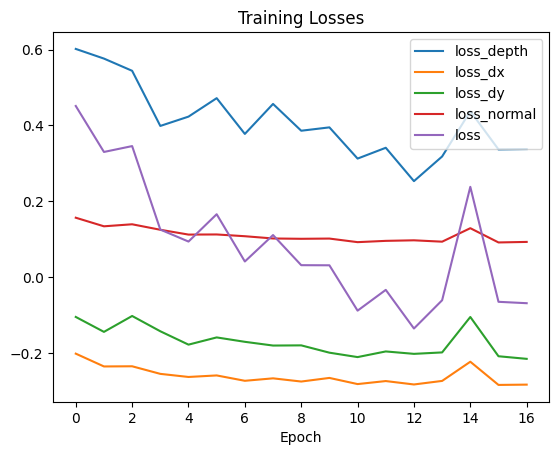

<Figure size 640x480 with 0 Axes>

In [7]:
results_df = pd.read_csv(training_progress_data)

plot_name = "training_loss_"+train_progress_file[7:-12]
plot_training_progress(results_df,"Training Losses", plot_name)

In [ ]:
resutls_csv_file_name2 = "train-results2.csv"
results_csv2 = download_path + "../outputs/results/" + resutls_csv_file_name2
results_df2 = pd.read_csv(results_csv2)
plot_results(results_df2,"Training Losses of second run")

### Testing the model (Expecting you ran above cells and already loaded the model)

In [8]:
import test
torch.cuda.empty_cache()


In [9]:

test_loader = getTestingData(5, "test_data.csv")
test.test(test_loader, model, 2e-04)

My Method in dataloader is:  Method.NOSEGMENTATIONCUES
test: 0
tensor(-2.2293)
tensor(2.2083)


/home/user/ethz/semester4/3dVision/.3d-env/lib/python3.11/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/user/ethz/semester4/3dVision/3DVision--Infusing-Monocular-Depth-Semantic/model/Revisiting_Single_Depth_Estimation-master/test.py:79: RuntimeWarning: invalid value encountered in scalar divide
  F = (2 * P * R) / (P + R) #precision and recall?


test: 1
tensor(-2.2293)
tensor(2.2083)
test: 2
tensor(-2.2293)
tensor(2.2083)
test: 3
tensor(-2.2129)
tensor(2.2083)
test: 4
tensor(-2.2293)
tensor(2.2083)
test: 5
tensor(-2.2293)
tensor(2.2083)
test: 6
tensor(-1.9996)
tensor(2.2083)
test: 7
tensor(-2.2293)
tensor(2.2083)
test: 8
tensor(-2.1308)
tensor(2.2083)
test: 9
tensor(-2.2293)
tensor(2.2083)
test: 10
tensor(-2.2293)
tensor(2.2083)
test: 11
tensor(-2.2129)
tensor(2.2083)
test: 12
tensor(-2.2293)
tensor(2.2083)
test: 13
tensor(-2.1473)
tensor(2.2083)
test: 14
tensor(-2.1801)
tensor(2.2083)
test: 15
tensor(-2.2129)
tensor(2.2083)
test: 16
tensor(-2.2293)
tensor(2.2083)
test: 17
tensor(-2.2293)
tensor(2.2083)
test: 18
tensor(-2.2293)
tensor(2.2083)
test: 19
tensor(-2.1637)
tensor(2.2083)
test: 20
tensor(-2.0980)
tensor(2.2083)
test: 21
tensor(-2.1473)
tensor(2.2083)
test: 22
tensor(-2.2293)
tensor(2.2083)
test: 23
tensor(-2.2293)
tensor(2.2083)
test: 24
tensor(-2.1965)
tensor(2.2083)
test: 25
tensor(-2.2129)
tensor(2.2083)
test: 26
